In [1]:
!pip install segment-anything opencv-python matplotlib torch torchvision
# Installing YOLOv8

In [3]:
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth

--2026-01-29 13:59:07--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.171.22.13, 3.171.22.33, 3.171.22.68, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|3.171.22.13|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 375042383 (358M) [binary/octet-stream]
Saving to: ‘sam_vit_b_01ec64.pth’

sam_vit_b_01ec64.pt 100%[===================>] 357.67M   281MB/s    in 1.3s    

2026-01-29 13:59:09 (281 MB/s) - ‘sam_vit_b_01ec64.pth’ saved [375042383/375042383]



In [4]:
import torch
import cv2
import numpy as np
import matplotlib.pyplot as plt
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator

sam_checkpoint = "sam_vit_b_01ec64.pth"  # download once
sam = sam_model_registry["vit_b"](checkpoint=sam_checkpoint)
sam.to("cuda" if torch.cuda.is_available() else "cpu")

mask_generator = SamAutomaticMaskGenerator(sam)


In [6]:
image = cv2.imread("img1.jpg")
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

In [7]:

masks = mask_generator.generate(image_rgb)
print("Raw masks detected:", len(masks))

Raw masks detected: 59


In [17]:
areas = np.array([m["area"] for m in masks])
medianarea = np.median(areas)

minarea = 0.3 * medianarea
maxarea = 2.0 * medianarea

candidates = [m for m in masks if minarea < m["area"] < maxarea]


In [18]:
def iou(mask1, mask2):
    inter = np.logical_and(mask1, mask2).sum()
    union = np.logical_or(mask1, mask2).sum()
    return inter / union

def containment(mask_small, mask_large):
    inter = np.logical_and(mask_small, mask_large).sum()
    return inter / mask_small.sum()   # % of small mask inside large


In [19]:
final_masks = []

for m in sorted(candidates, key=lambda x: x["area"], reverse=True):
    keep = True
    for fm in final_masks:
        if iou(m["segmentation"], fm["segmentation"]) > 0.6:
            keep = False
            break
        if containment(m["segmentation"], fm["segmentation"]) > 0.8:
            keep = False
            break

    if keep:
        final_masks.append(m)

print("Final screw count:", len(final_masks))


Final screw count: 43


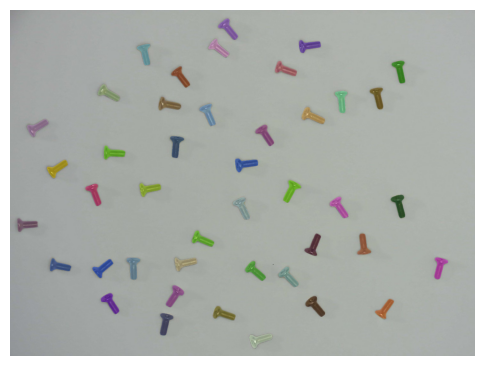

Accuracy: 100.00%


In [20]:
overlay = image_rgb.copy()

for m in final_masks:
    seg = m["segmentation"]
    color = np.random.randint(0,255,3)
    overlay[seg] = overlay[seg]*0.5 + color*0.5

plt.figure(figsize=(6,6))
plt.imshow(overlay.astype(np.uint8))
plt.axis("off")
plt.show()


ground_truth = 43
predicted = len(final_masks)   # from AI model

accuracy = 1 - abs(predicted - ground_truth) / ground_truth
print(f"Accuracy: {accuracy * 100:.2f}%")
